# PVNet – Possession Value Network (training only in Colab)

This notebook:
1) mounts Google Drive
2) downloads / uploads StatsBomb Open Data
3) creates event dataset with feature engineering
4) defines labels: shot_within_K and goal_within_K
5) splits by match (train/val/test)
6) trains PyTorch multitask (shot + goal)
7) evaluates and saves:
   - artifacts/model.pth
   - artifacts/metrics.json
   - artifacts/test_predictions.parquet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
from pathlib import Path

PROJECT_ROOT = Path("/content/drive/MyDrive/pvnet-football")
SRC_ROOT = PROJECT_ROOT / "src"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_ROOT:", SRC_ROOT)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/pvnet-football
SRC_ROOT: /content/drive/MyDrive/pvnet-football/src
ARTIFACTS_DIR: /content/drive/MyDrive/pvnet-football/artifacts


In [3]:
!pip -q install statsbombpy pandas numpy scikit-learn pyarrow fastparquet matplotlib torch tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.6 MB/s eta 0:00:00


In [4]:
from config import Config
from data.load_statsbomb import load_competition_events
from data.preprocessing import basic_clean, build_features
from data.labeling import add_future_labels
from data.split import split_by_match
from training.utils import set_seed, get_device

cfg = Config()
set_seed(cfg.RANDOM_SEED)
device = get_device()
print("Device:", device)


Device: cuda


In [5]:
from statsbombpy import sb
comps = sb.competitions()
comps[["competition_id","season_id","competition_name","season_name","country_name"]].sort_values(
    ["competition_name","season_id"], ascending=[True, False]
).head(60)


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,competition_id,season_id,competition_name,season_name,country_name
0,9,281,1. Bundesliga,2023/2024,Germany
1,9,27,1. Bundesliga,2015/2016,Germany
2,1267,107,African Cup of Nations,2023,Africa
18,16,277,Champions League,1972/1973,Europe
20,16,276,Champions League,1970/1971,Europe
17,16,76,Champions League,1999/2000,Europe
19,16,71,Champions League,1971/1972,Europe
16,16,44,Champions League,2003/2004,Europe
13,16,41,Champions League,2008/2009,Europe
14,16,39,Champions League,2006/2007,Europe


In [6]:
import pandas as pd

COMPETITIONS = [
    # Esempi: sostituisci con quelle che trovi in comps
    (223, 282),   # Copa America 2024
    (1267, 107),  # Africa Cup of Nations
    (43, 106),  # FIFA World Cup 2022
    (16, 4)   # Champions League 2018/2019
]

all_events = []
for comp_id, season_id in COMPETITIONS:
    try:
        ev = load_competition_events(comp_id, season_id, include_freeze_frame=False)
        ev["competition_id"] = comp_id
        ev["season_id"] = season_id
        all_events.append(ev)
        print(f"OK -> comp={comp_id}, season={season_id}, rows={len(ev)}")
    except Exception as e:
        print(f"SKIP -> comp={comp_id}, season={season_id} | {type(e).__name__}: {e}")

events_raw = pd.concat(all_events, ignore_index=True)
print("TOTAL events_raw:", events_raw.shape)
events_raw.head(3)


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: 

OK -> comp=223, season=282, rows=100305


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: 

OK -> comp=1267, season=107, rows=162910


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: 

OK -> comp=43, season=106, rows=234652
OK -> comp=16, season=4, rows=3165
TOTAL events_raw: (501032, 117)


,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,...,goalkeeper_penalty_saved_to_post,shot_open_goal,competition_id,season_id,goalkeeper_shot_saved_off_target,shot_saved_off_target,player_off_permanent,shot_follows_dribble,half_start_late_video_start,goalkeeper_success_in_play
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,223,282,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,223,282,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,223,282,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = basic_clean(events_raw)
df = build_features(df)
df = add_future_labels(df, k=cfg.K_FUTURE_EVENTS)

# optional: filter out events without location (e.g., some substitutions, etc.)
df = df[df["location"].notna()].reset_index(drop=True)

print(df.shape)
df[["type_name","shot_within_k","goal_within_k"]].value_counts().head(10)


(495735, 141)


,,,count
type_name,shot_within_k,goal_within_k,
Pass,0,0,135405
Ball Receipt*,0,0,126172
Carry,0,0,105077
Pressure,0,0,38588
Ball Recovery,0,0,12216
Duel,0,0,9042
Ball Receipt*,1,0,5808
Pass,1,0,5679
Clearance,0,0,5650


In [8]:
import numpy as np

FEATURE_COLS = [
    "start_x","start_y","end_x","end_y",
    "dist_to_goal","angle_to_goal_center",
    "dx","dy","progress_x",
    "time_seconds",
    "is_pass","is_carry","is_dribble","is_shot",
    "pass_success","dribble_success",
]

X = df[FEATURE_COLS].astype(float).values
y_shot = df["shot_within_k"].astype(int).values
y_goal = df["goal_within_k"].astype(int).values

print("X:", X.shape, "shot pos_rate:", y_shot.mean(), "goal pos_rate:", y_goal.mean())


X: (495735, 16) shot pos_rate: 0.051511392175254925 goal pos_rate: 0.00530121940149475


In [9]:
train_df, val_df, test_df = split_by_match(
    df,
    train_frac=cfg.TRAIN_FRAC,
    val_frac=cfg.VAL_FRAC,
    test_frac=cfg.TEST_FRAC,
    seed=cfg.RANDOM_SEED
)

def to_xy(d):
    Xd = d[FEATURE_COLS].astype(float).values
    ys = d["shot_within_k"].astype(int).values
    yg = d["goal_within_k"].astype(int).values
    return Xd, ys, yg

X_train, y_train_shot, y_train_goal = to_xy(train_df)
X_val, y_val_shot, y_val_goal = to_xy(val_df)
X_test, y_test_shot, y_test_goal = to_xy(test_df)

X_train.shape, X_val.shape, X_test.shape


((343852, 16), (75289, 16), (76594, 16))

In [10]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

SCALER_PATH = ARTIFACTS_DIR / "scaler.joblib"
joblib.dump(scaler, SCALER_PATH)
print("Saved scaler:", SCALER_PATH)


Saved scaler: /content/drive/MyDrive/pvnet-football/artifacts/scaler.joblib


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

from models.pvnet import PVNet
from training.train_loop import make_loader, train_one_epoch, eval_one_epoch

train_loader = make_loader(X_train_s, y_train_shot, y_train_goal, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_loader   = make_loader(X_val_s, y_val_shot, y_val_goal, batch_size=cfg.BATCH_SIZE, shuffle=False)
test_loader  = make_loader(X_test_s, y_test_shot, y_test_goal, batch_size=cfg.BATCH_SIZE, shuffle=False)

model = PVNet(in_dim=X_train_s.shape[1], hidden_dim=cfg.HIDDEN_DIM, dropout=cfg.DROPOUT).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)

print(model)


PVNet(
  (net): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [12]:
from tqdm import tqdm

best_val = float("inf")
best_state = None
pat = 0

history = []

for epoch in range(1, cfg.EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_logits, va_y = eval_one_epoch(model, val_loader, criterion, device)

    history.append({"epoch": epoch, "train_loss": tr_loss, "val_loss": va_loss})
    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.5f} | val_loss={va_loss:.5f}")

    if va_loss < best_val - 1e-5:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1
        if pat >= cfg.EARLY_STOPPING_PATIENCE:
            print("Early stopping.")
            break

model.load_state_dict(best_state)
print("Best val_loss:", best_val)


Epoch 01 | train_loss=0.18529 | val_loss=0.11125
Epoch 02 | train_loss=0.11266 | val_loss=0.10343
Epoch 03 | train_loss=0.10607 | val_loss=0.09811
Epoch 04 | train_loss=0.10313 | val_loss=0.09686
Epoch 05 | train_loss=0.10205 | val_loss=0.09619
Epoch 06 | train_loss=0.10143 | val_loss=0.09593
Epoch 07 | train_loss=0.10090 | val_loss=0.09563
Epoch 08 | train_loss=0.10080 | val_loss=0.09555
Epoch 09 | train_loss=0.10060 | val_loss=0.09550
Epoch 10 | train_loss=0.10036 | val_loss=0.09536
Epoch 11 | train_loss=0.10011 | val_loss=0.09526
Epoch 12 | train_loss=0.10004 | val_loss=0.09510
Best val_loss: 0.09510035582466574


In [14]:
from training.evaluate import compute_metrics, calibration_data
import json
from pathlib import Path # Import Path to check for PosixPath objects

test_loss, test_logits, test_y = eval_one_epoch(model, test_loader, criterion, device)
metrics, test_probs = compute_metrics(test_logits, test_y)
calib = calibration_data(test_probs, test_y, n_bins=10)

# Create a serializable version of cfg.__dict__
serializable_config = {}
for k, v in cfg.__dict__.items():
    if isinstance(v, Path): # Check if the value is a Path object
        serializable_config[k] = str(v) # Convert Path to string
    else:
        serializable_config[k] = v

out = {
    "test_loss": float(test_loss),
    "metrics": metrics,
    "calibration": calib,
    "config": serializable_config, # Use the serializable_config here
    "feature_cols": FEATURE_COLS,
}

METRICS_PATH = ARTIFACTS_DIR / "metrics.json"
with open(METRICS_PATH, "w") as f:
    json.dump(out, f, indent=2)

print("Saved metrics:", METRICS_PATH)
print(json.dumps(metrics, indent=2))


Saved metrics: /content/drive/MyDrive/pvnet-football/artifacts/metrics.json
{
  "shot": {
    "roc_auc": 0.8106440117065675,
    "pr_auc": 0.2679699815229988,
    "log_loss": 0.156036838878529,
    "brier": 0.03970680218362533,
    "pos_rate": 0.047444969579862654
  },
  "goal": {
    "roc_auc": 0.8243300602708098,
    "pr_auc": 0.052436314177863486,
    "log_loss": 0.026094987926907336,
    "brier": 0.004639358393673229,
    "pos_rate": 0.004765386322688461
  }
}


In [15]:
import numpy as np
import pandas as pd
import torch

# =========================
# 1) Build test_out + probs
# =========================
test_out = test_df.copy().reset_index(drop=True)

test_out["p_shot"] = test_probs[:, 0]
test_out["p_goal"] = test_probs[:, 1]

test_feat = test_df[FEATURE_COLS].astype(float).values
test_feat_s = scaler.transform(test_feat)

# =========================
# 2) Stato after
# =========================
next_idx = (
    test_out.index.to_series()
        .groupby([test_out["match_id"], test_out["possession"]])
        .shift(-1)
)
next_idx = next_idx.fillna(-1).astype(int).values

X_after = test_feat_s.copy()
mask = next_idx >= 0
X_after[mask] = test_feat_s[next_idx[mask]]

model.eval()
with torch.no_grad():
    logits_after = model(torch.tensor(X_after, dtype=torch.float32).to(device)).cpu().numpy()

p_after = 1 / (1 + np.exp(-logits_after))
test_out["p_shot_after"] = p_after[:, 0]
test_out["p_goal_after"] = p_after[:, 1]

# =========================
# 3) Action value
# =========================
w_goal = 5.0
test_out["action_value_raw"] = (
    (test_out["p_shot_after"] - test_out["p_shot"]) +
    w_goal * (test_out["p_goal_after"] - test_out["p_goal"])
)

VALID_ACTIONS = {"Pass", "Carry", "Dribble", "Shot"}
test_out["is_valid_action"] = test_out["type_name"].isin(VALID_ACTIONS)

has_end = (
    test_out["pass_end_location"].notna() |
    test_out["carry_end_location"].notna() |
    test_out["shot_end_location"].notna()
).fillna(False)

test_out["action_value_dashboard"] = np.where(
    test_out["is_valid_action"] & has_end,
    test_out["action_value_raw"],
    0.0
)

valid_vals = test_out.loc[test_out["action_value_dashboard"] != 0.0, "action_value_dashboard"].values
if len(valid_vals) > 0:
    lo, hi = np.quantile(valid_vals, [0.01, 0.99])
    test_out["action_value_dashboard"] = test_out["action_value_dashboard"].clip(lo, hi)

test_out["minute"] = pd.to_numeric(test_out["minute"], errors="coerce").fillna(0).astype(int)
test_out["minute_bucket"] = (test_out["minute"] // 5) * 5
test_out["value_pos"] = test_out["action_value_dashboard"].clip(lower=0)
test_out["value_neg"] = test_out["action_value_dashboard"].clip(upper=0)

# =========================
# 4) Save test predictions
# =========================
PRED_PATH = ARTIFACTS_DIR / "test_predictions.parquet"
test_out.to_parquet(PRED_PATH, index=False)

# =========================
# 5) Ranking player (outfield vs GK-like proxy)
# =========================
actions_df = test_out[test_out["action_value_dashboard"] != 0.0].copy()

player_depth = (
    actions_df.assign(is_deep=(actions_df["start_x"] < 20).astype(int))
    .groupby(["player_name", "team_name"])["is_deep"]
    .mean()
    .reset_index()
    .rename(columns={"is_deep": "deep_action_rate"})
)

player_ranking = (
    actions_df.groupby(["player_name", "team_name"], dropna=False)
    .agg(
        value_total=("action_value_dashboard", "sum"),
        actions=("action_value_dashboard", "size"),
        value_mean=("action_value_dashboard", "mean"),
        value_median=("action_value_dashboard", "median"),
        value_pos_total=("value_pos", "sum"),
        value_neg_total=("value_neg", "sum"),
    )
    .reset_index()
    .merge(player_depth, on=["player_name", "team_name"], how="left")
)

player_ranking["value_per_100_actions"] = player_ranking["value_total"] * (100.0 / player_ranking["actions"].clip(lower=1))
player_ranking["is_reliable"] = player_ranking["actions"] >= 50

OUTFIELD_MAX_DEEP_RATE = 0.60
outfield = player_ranking[player_ranking["deep_action_rate"] <= OUTFIELD_MAX_DEEP_RATE].copy()
gk_like  = player_ranking[player_ranking["deep_action_rate"] >  OUTFIELD_MAX_DEEP_RATE].copy()

OUTFIELD_PATH = ARTIFACTS_DIR / "player_ranking_outfield.parquet"
GK_PATH = ARTIFACTS_DIR / "player_ranking_goalkeepers.parquet"
outfield.to_parquet(OUTFIELD_PATH, index=False)
gk_like.to_parquet(GK_PATH, index=False)

# =========================
# 6) Team match ranking
# =========================
team_match = (
    actions_df.groupby(["match_id", "team_name"], dropna=False)
    .agg(
        team_value_total=("action_value_dashboard", "sum"),
        actions=("action_value_dashboard", "size"),
        team_value_per_100=("action_value_dashboard", lambda s: s.sum() * (100.0 / max(len(s), 1))),
    )
    .reset_index()
)
TEAM_MATCH_PATH = ARTIFACTS_DIR / "team_match_ranking.parquet"
team_match.to_parquet(TEAM_MATCH_PATH, index=False)

print("Saved test predictions:", PRED_PATH)
print("Saved outfield ranking:", OUTFIELD_PATH)
print("Saved GK-like ranking:", GK_PATH)
print("Saved team-match ranking:", TEAM_MATCH_PATH)

display(test_out[["type_name","player_name","team_name","p_shot","p_goal","action_value_dashboard"]].head(12))
display(outfield[outfield["is_reliable"]].sort_values("value_per_100_actions", ascending=False).head(15))


Saved test predictions: /content/drive/MyDrive/pvnet-football/artifacts/test_predictions.parquet
Saved outfield ranking: /content/drive/MyDrive/pvnet-football/artifacts/player_ranking_outfield.parquet
Saved GK-like ranking: /content/drive/MyDrive/pvnet-football/artifacts/player_ranking_goalkeepers.parquet
Saved team-match ranking: /content/drive/MyDrive/pvnet-football/artifacts/team_match_ranking.parquet


,type_name,player_name,team_name,p_shot,p_goal,action_value_dashboard
0,Pass,Aleksandar Mitrović,Serbia,0.006591,0.000300,0.019943
1,Ball Receipt*,Saša Lukić,Serbia,0.018274,0.001952,0.000000
2,Carry,Saša Lukić,Serbia,0.007242,0.000378,-0.006660
3,Pass,Saša Lukić,Serbia,0.002174,0.000060,0.019409
4,Ball Receipt*,Strahinja Pavlović,Serbia,0.015400,0.001296,0.000000
5,Carry,Strahinja Pavlović,Serbia,0.005484,0.000247,-0.003675
6,Pass,Strahinja Pavlović,Serbia,0.002808,0.000047,0.069577
7,Ball Receipt*,Milos Veljkovic,Serbia,0.050068,0.004511,0.000000
8,Carry,Milos Veljkovic,Serbia,0.007355,0.000206,0.181806
9,Pressure,Jean-Eric Maxim Choupo-Moting,Cameroon,0.136413,0.010756,0.000000


,player_name,team_name,value_total,actions,value_mean,value_median,value_pos_total,value_neg_total,deep_action_rate,value_per_100_actions,is_reliable
342,Nader Ghandri,Tunisia,2.092925,51,0.041038,0.010191,2.207814,-0.114888,0.078431,4.103775,True
474,Willian Joel Pacho Tenorio,Ecuador,6.521709,164,0.039767,0.008216,7.181347,-0.659639,0.201220,3.976652,True
3,Abdelkarim Hassan Al Haj Fadlalla,Qatar,2.808408,78,0.036005,0.012996,3.745096,-0.936688,0.153846,3.600523,True
429,Siyanda Xulu,South Africa,3.820646,107,0.035707,0.013174,3.976218,-0.155572,0.084112,3.570698,True
190,Issiaga Sylla,Guinea,2.012148,57,0.035301,0.011294,2.758071,-0.745923,0.017544,3.530085,True
338,Mothobi Mvala,South Africa,5.791778,166,0.034890,0.012534,6.949183,-1.157405,0.060241,3.489023,True
176,Héctor Alfredo Moreno Herrera,Mexico,2.845577,82,0.034702,0.010830,3.119652,-0.274075,0.036585,3.470216,True
151,Gomolemo Grant Kekana,South Africa,5.977230,176,0.033962,0.012998,6.304206,-0.326976,0.107955,3.396153,True
27,Alexander Djiku,Ghana,1.616656,51,0.031699,0.009300,1.685827,-0.069171,0.098039,3.169913,True
167,Hassan Mohammed Al-Tambakti,Saudi Arabia,1.584431,50,0.031689,0.011538,2.062977,-0.478546,0.080000,3.168863,True


In [16]:
import torch

MODEL_PATH = ARTIFACTS_DIR / "model.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "in_dim": X_train_s.shape[1],
    "feature_cols": FEATURE_COLS,
    "hidden_dim": cfg.HIDDEN_DIM,
    "dropout": cfg.DROPOUT,
}, MODEL_PATH)

print("Saved model:", MODEL_PATH)


Saved model: /content/drive/MyDrive/pvnet-football/artifacts/model.pth


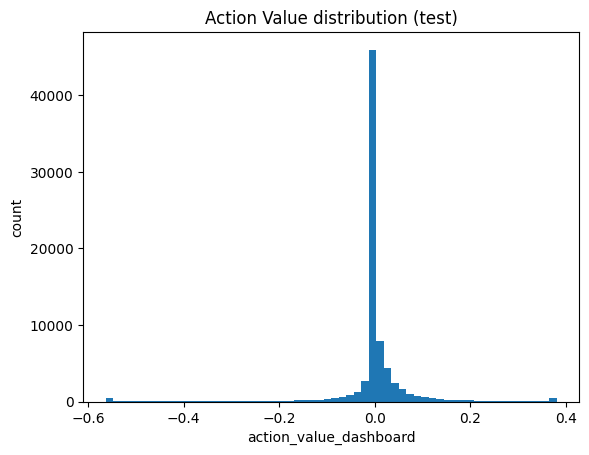

,action_value_dashboard
player_name,
Damián Emiliano Martínez,15.028738
Ronwen Williams,10.042608
Cristian Gabriel Romero,9.699549
Nicolás Hernán Otamendi,9.606777
Lisandro Martínez,7.288328
Willian Joel Pacho Tenorio,6.521709
Yassine Meriah,6.472877
Felix Eduardo Torres Caicedo,6.471499
Walker Zimmerman,6.039513


In [17]:
import matplotlib.pyplot as plt

vals = test_out["action_value_dashboard"].values
plt.figure()
plt.hist(vals, bins=60)
plt.title("Action Value distribution (test)")
plt.xlabel("action_value_dashboard")
plt.ylabel("count")
plt.show()

top_players = (
    test_out.groupby("player_name")["action_value_dashboard"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_players


In [ ]:
from statsbombpy import sb
sb.competitions()[[
    "competition_id","season_id",
    "competition_name","season_name","country_name"
]]


/usr/local/lib/python3.12/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,competition_id,season_id,competition_name,season_name,country_name
0,9,281,1. Bundesliga,2023/2024,Germany
1,9,27,1. Bundesliga,2015/2016,Germany
2,1267,107,African Cup of Nations,2023,Africa
3,16,4,Champions League,2018/2019,Europe
4,16,1,Champions League,2017/2018,Europe
...,...,...,...,...,...
70,35,75,UEFA Europa League,1988/1989,Europe
71,53,315,UEFA Women's Euro,2025,Europe
72,53,106,UEFA Women's Euro,2022,Europe
73,72,107,Women's World Cup,2023,International
